# CS 133 Final Project - Police Killings 2015 DataSet #

### Import Necessary Dependencies ###

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_predict


### Load the DataSet ###

In [18]:
data = pd.read_csv("https://raw.githubusercontent.com/csbfx/cs133/main/police_killing.csv")

### Ensure DataSet Formatting ###

In [19]:
data.head()

,age,gender,raceethnicity,month,year,city,state,latitude,longitude,lawenforcementagency,...,share_white,share_black,share_hispanic,p_income,h_income,county_income,comp_income,pov,urate,college
0,16,Male,Black,February,2015,Millbrook,AL,32.529577,-86.362829,Millbrook Police Department,...,60.5,30.5,5.6,28375,51367.0,54766,0.937936,14.1,0.097686,0.168510
1,27,Male,White,April,2015,Pineville,LA,31.321739,-92.434860,Rapides Parish Sheriff's Office,...,53.8,36.2,0.5,14678,27972.0,40930,0.683411,28.8,0.065724,0.111402
2,26,Male,White,March,2015,Kenosha,WI,42.583560,-87.835710,Kenosha Police Department,...,73.8,7.7,16.8,25286,45365.0,54930,0.825869,14.6,0.166293,0.147312
3,25,Male,Hispanic/Latino,March,2015,South Gate,CA,33.939298,-118.219463,South Gate Police Department,...,1.2,0.6,98.8,17194,48295.0,55909,0.863814,11.7,0.124827,0.050133
4,29,Male,White,March,2015,Munroe Falls,OH,41.148575,-81.429878,Kent Police Department,...,92.5,1.4,1.7,33954,68785.0,49669,1.384868,1.9,0.063550,0.403954


### Preprocessing and Data conversion/Feature Engineering ###

In [20]:
# Create a copy of the original dataset and standardize column names
df = data.copy()
df.columns = [col.lower() for col in df.columns]

# Remove rows with 'Unknown' values in any column
df.replace('Unknown', np.nan, inplace=True)
df.dropna(inplace=True)

# Convert specified columns to their appropriate types
columns_to_convert = {
    'pop': float,
    'share_white': float,
    'share_black': float,
    'share_hispanic': float,
    'p_income': int,
    'h_income': int,
    'county_income': int,
    'pov': float,
    'college': float,
    'age': int
}

# Iterate over the columns and convert
for column, dtype in columns_to_convert.items():
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Convert to numeric, coercing invalid values to NaN
    if dtype == int:
        df[column].fillna(df[column].median(), inplace=True)  # Replace NaN with median for int columns
        df[column] = df[column].astype(int)  # Convert to integer
    elif dtype == float:
        df[column].fillna(df[column].mean(), inplace=True)  # Replace NaN with mean for float columns
        df[column] = df[column].astype(float)  # Convert to float



# Add a new column `is_armed` to classify armed status
df['is_armed'] = (df['armed'] != 'No').astype(int)

# Ensure target variable has at least two classes
if df['is_armed'].nunique() < 2:
    raise ValueError("Target variable must have at least two classes.")

# Convert categorical variables to numeric
categorical_columns = ['gender', 'raceethnicity', 'cause']
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Select relevant features based on project questions
features = [
    'age', 'gender', 'raceethnicity','p_income', 'pov', 'urate', 'college', 'share_white', 'share_black', 'share_hispanic'
]

# Separate features and target variable
X = df[features]
y = df['is_armed']


<ipython-input-20-f75e89c981e3>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)  # Replace NaN with mean for float columns
<ipython-input-20-f75e89c981e3>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 

### Model Training, Testing, and Evaluation ###

In [21]:
# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize pipelines
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),  # Scaling features
        ('classifier', LogisticRegression())  # Classifier
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()),  # Scaling features
        ('classifier', RandomForestClassifier())  # Classifier
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),  # Scaling features
        ('classifier', SVC())  # Classifier
    ])
}


# Initialize results and trained models dictionaries
results = {}
trained_models = {}

# Train and evaluate each model using 5-fold cross-validation
for name, pipeline in pipelines.items():
    print(f"\nEvaluating {name} with 5-fold cross-validation:")

    # Cross-validated predictions
    y_pred = cross_val_predict(pipeline, X, y, cv=cv)

    # Fit the pipeline on the entire training set for final storage
    pipeline.fit(X, y)
    trained_models[name] = pipeline

    # Calculate evaluation metrics
    results[name] = {
        'Accuracy': accuracy_score(y, y_pred),
        'F1 Score': f1_score(y, y_pred, average='weighted'),  # Weighted for multi-class
        'Confusion Matrix': confusion_matrix(y, y_pred)
    }

    # Print the evaluation metrics for the current model
    print(f"Accuracy: {results[name]['Accuracy']:.4f}")
    print(f"F1 Score: {results[name]['F1 Score']:.4f}")
    print(f"Confusion Matrix:\n{results[name]['Confusion Matrix']}")


Evaluating Logistic Regression with 5-fold cross-validation:
Accuracy: 0.7717
F1 Score: 0.6805
Confusion Matrix:
[[  2  98]
 [  2 336]]

Evaluating Random Forest with 5-fold cross-validation:
Accuracy: 0.7283
F1 Score: 0.6604
Confusion Matrix:
[[  3  97]
 [ 22 316]]

Evaluating SVM with 5-fold cross-validation:
Accuracy: 0.7717
F1 Score: 0.6722
Confusion Matrix:
[[  0 100]
 [  0 338]]


### Confusion matrices for model evaluation visualized ###

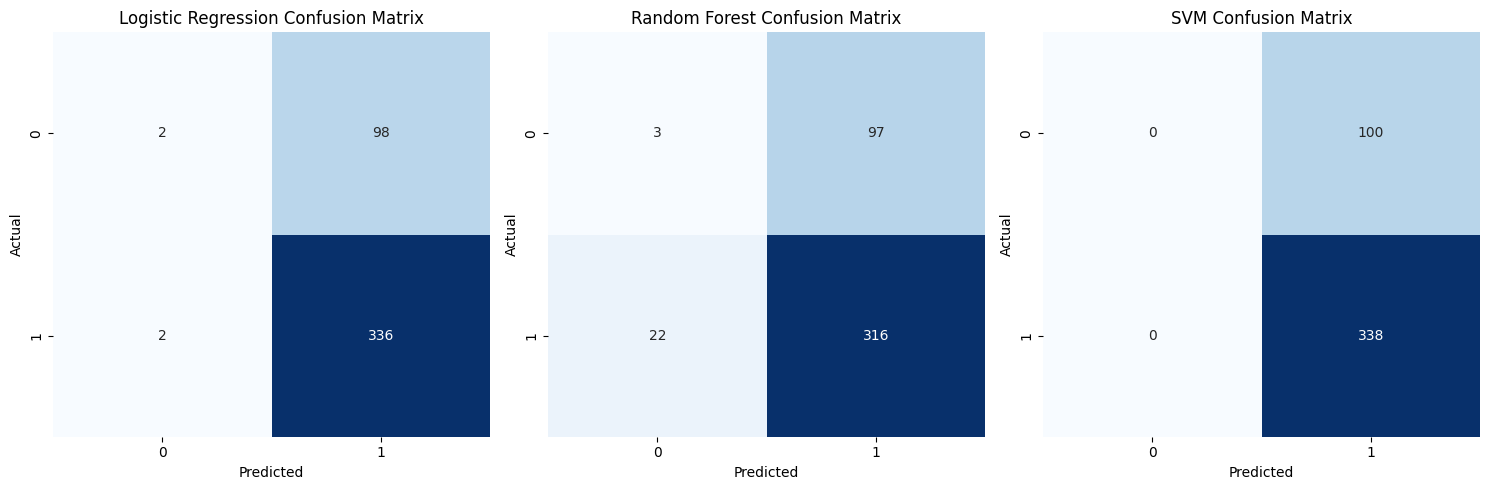

In [22]:
plt.figure(figsize=(15, 5))
for i, (model, metrics) in enumerate(results.items(), 1):
    confusion_mat = metrics['Confusion Matrix']
    plt.subplot(1, len(results), i)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{model} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


### Data Exploration Graphs and Visualizations ###

Race/Ethnicity Mapping:
{1: 0, 4: 1, 2: 2, 0: 3, 3: 4}


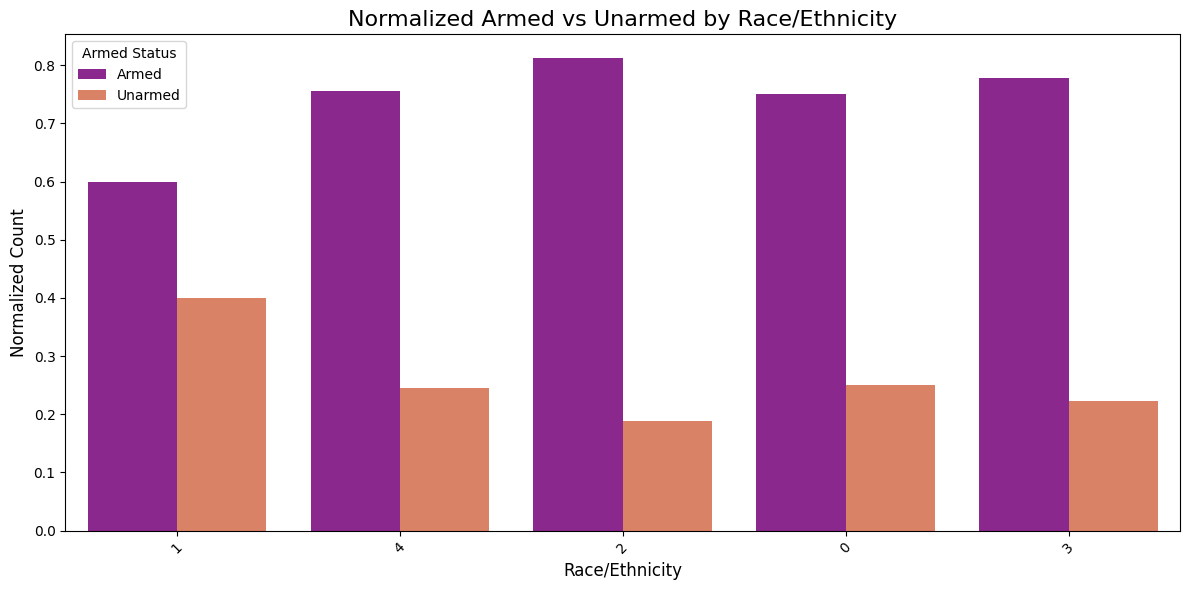

In [23]:
# Step 1: Encode 'raceethnicity' to numerical labels
race_mapping = {value: idx for idx, value in enumerate(df['raceethnicity'].unique())}
df['raceethnicity_encoded'] = df['raceethnicity'].map(race_mapping)
df['is_armed'] = df['is_armed'].replace({0: 'Unarmed', 1: 'Armed'})

# Print mapping for reference
print("Race/Ethnicity Mapping:")
print(race_mapping)

# Step 2: Compute normalized data
race_counts = df['raceethnicity'].value_counts()
normalized_data = (
    df.groupby(['raceethnicity', 'is_armed']).size() / race_counts
).reset_index(name='normalized_count')

# Step 3: Create barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=normalized_data,
    x='raceethnicity',
    y='normalized_count',
    hue='is_armed',
    palette='plasma'
)

# Step 4: Update the x-axis with race/ethnicity names
raceethnicity_names = [key for key, value in sorted(race_mapping.items(), key=lambda item: item[1])]
plt.xticks(
    ticks=range(len(raceethnicity_names)),
    labels=raceethnicity_names,
    rotation=45
)

# Customize the plot
plt.title('Normalized Armed vs Unarmed by Race/Ethnicity', fontsize=16)
plt.xlabel('Race/Ethnicity', fontsize=12)
plt.ylabel('Normalized Count', fontsize=12)
plt.legend(title='Armed Status')
plt.tight_layout()

# Show the plot
plt.show()

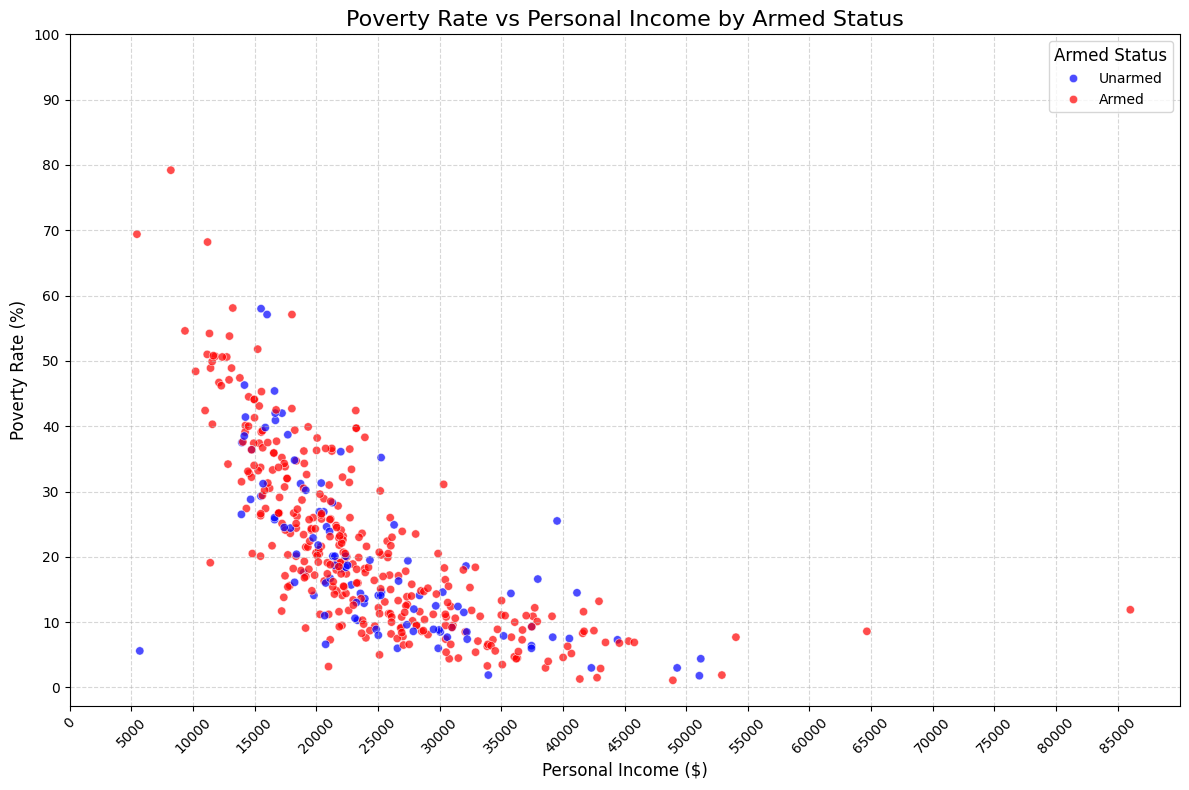

In [24]:
# Map the is_armed column to 'Unarmed' and 'Armed'
df['armed_status'] = df['is_armed'].replace({0: 'Unarmed', 1: 'Armed'})

# Scatter plot of poverty rate vs income by armed status
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='p_income',
    y='pov',
    hue='armed_status',  # Use the mapped column for the legend
    data=df,
    palette={'Unarmed': 'blue', 'Armed': 'red'},  # Custom blue/red palette
    alpha=0.7
)

# Titles and axis labels
plt.title('Poverty Rate vs Personal Income by Armed Status', fontsize=16)
plt.xlabel('Personal Income ($)', fontsize=12)
plt.ylabel('Poverty Rate (%)', fontsize=12)

# Adjust ticks
plt.xticks(ticks=range(0, int(df['p_income'].max()) + 1, 5000), fontsize=10, rotation=45)
plt.yticks(ticks=range(0, 101, 10), fontsize=10)

# Add gridlines
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Adjust the legend
plt.legend(title='Armed Status', title_fontsize=12, fontsize=10, loc='upper right')

# Tight layout and show the plot
plt.tight_layout()
plt.show()

Value counts after mapping:
raceethnicity
White                     229
Black                     131
Hispanic/Latino            64
Asian/Pacific Islander     10
Native American             4
Name: count, dtype: int64


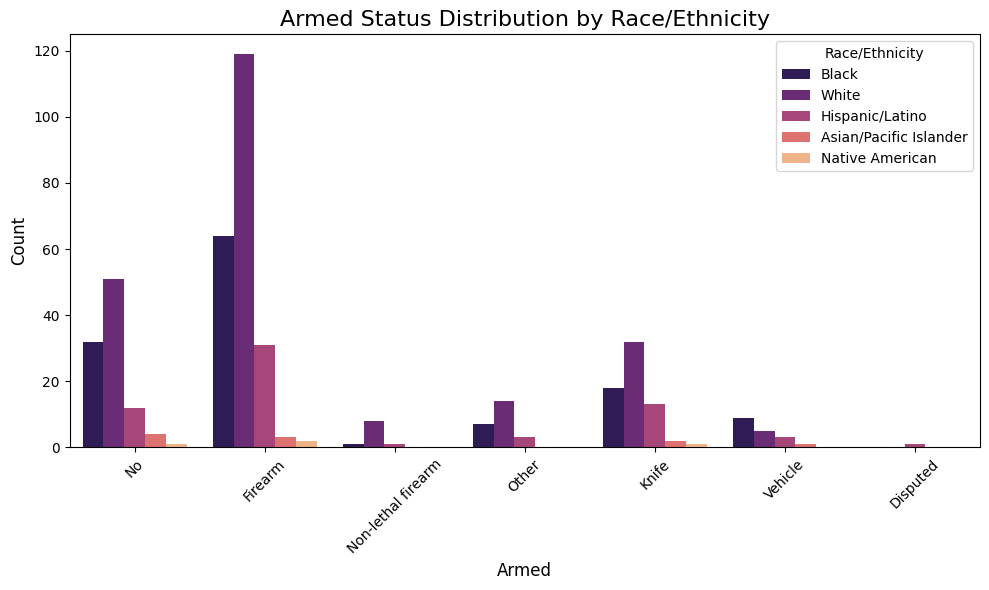

In [25]:
# Correct mapping based on the correct order from le.classes_
raceethnicity_mapping = {
    0: 'Asian/Pacific Islander',
    1: 'Black',
    2: 'Hispanic/Latino',
    3: 'Native American',
    4: 'White',
    5: 'Unknown'
}

# Map the encoded values back to labels
df['raceethnicity'] = df['raceethnicity'].map(raceethnicity_mapping)

# Validate the counts
print("Value counts after mapping:")
print(df['raceethnicity'].value_counts())

# Recreate the plot
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df,
    x='armed',
    hue='raceethnicity',
    palette='magma'
)
plt.title('Armed Status Distribution by Race/Ethnicity', fontsize=16)
plt.xlabel('Armed', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Race/Ethnicity', loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()


<ipython-input-26-3fb76e3dc7b6>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


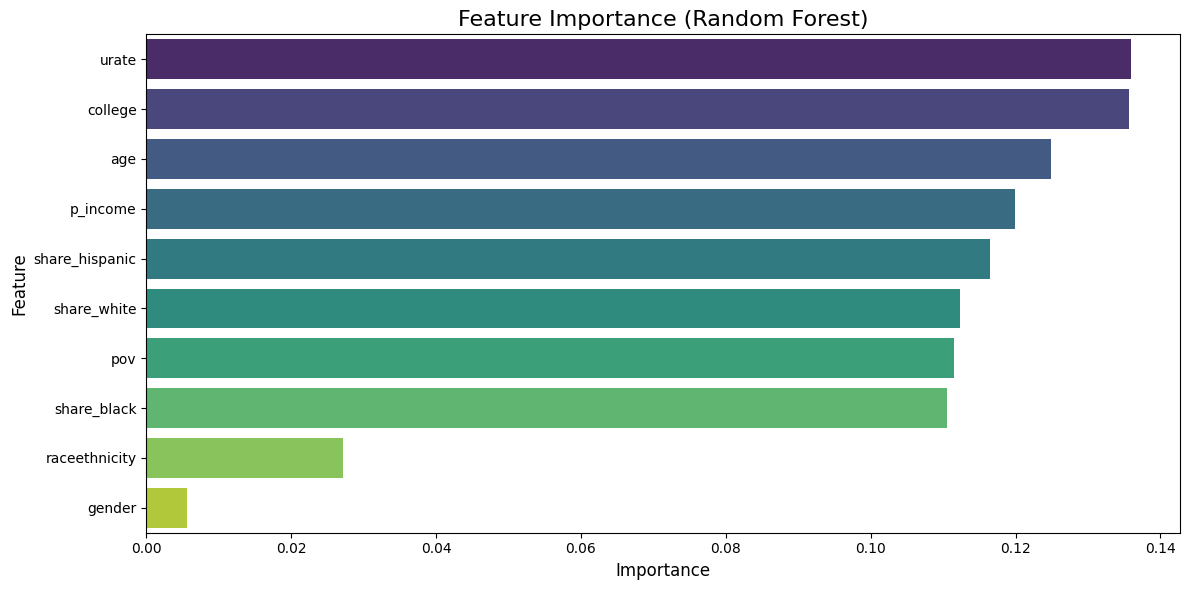

In [26]:
# Extract feature importance for Random Forest
rf_model = trained_models["Random Forest"].named_steps['classifier']
importances = rf_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(
    x=importances[sorted_indices],
    y=np.array(X.columns)[sorted_indices],
    palette='viridis'
)
plt.title('Feature Importance (Random Forest)', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


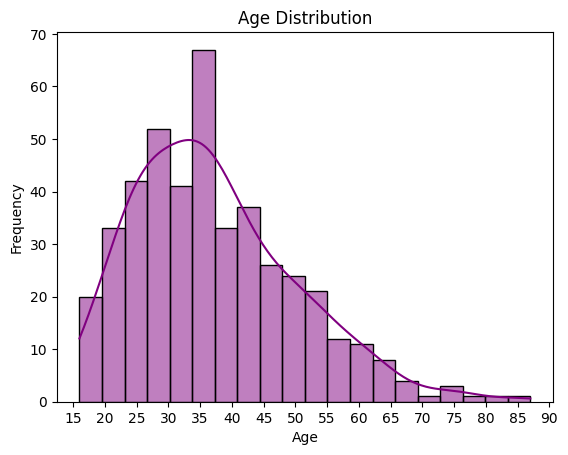

In [27]:
sns.histplot(data=df, x='age', bins=20, kde=True, color = 'purple')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Set the x-axis ticks to 5-year intervals
min_age, max_age = df['age'].min(), df['age'].max()
plt.xticks(range(min_age - min_age % 5, max_age + 6, 5))  # Adjust to nearest multiple of 5

plt.show()


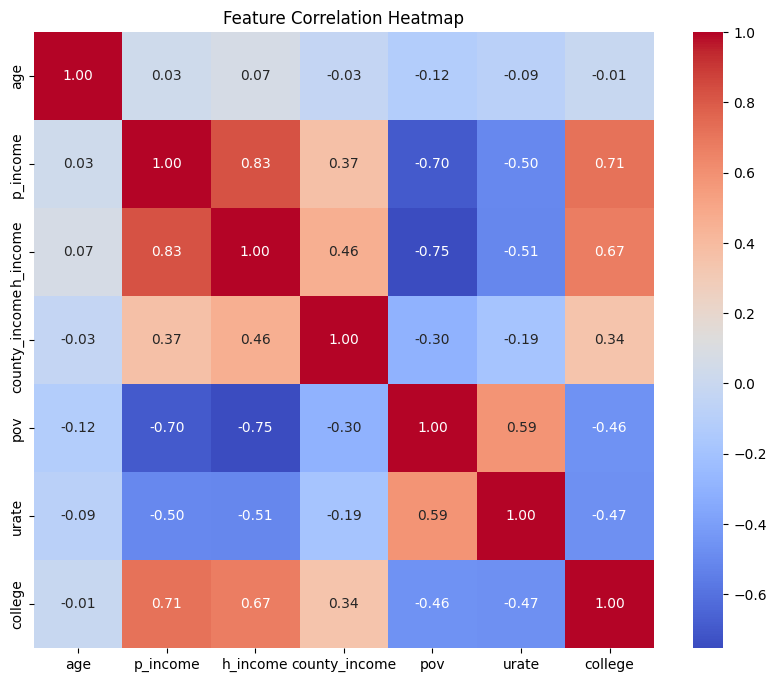

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[['age', 'p_income', 'h_income', 'county_income', 'pov', 'urate', 'college']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

<ipython-input-29-ab81dd5d9ead>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='raceethnicity', y='college', palette='viridis', ci=None)
<ipython-input-29-ab81dd5d9ead>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='raceethnicity', y='college', palette='viridis', ci=None)


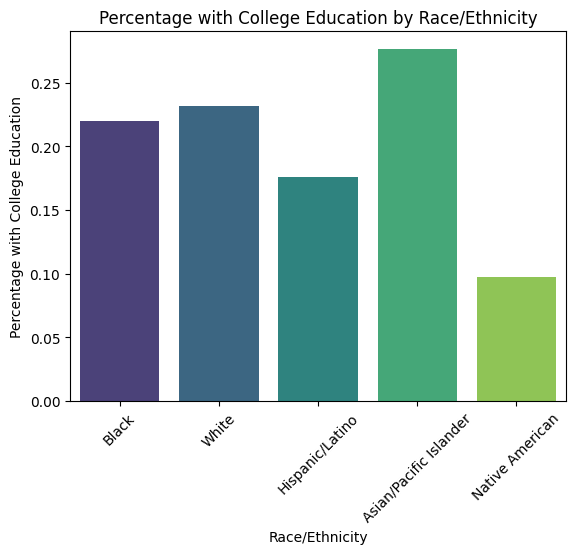

In [29]:
sns.barplot(data=df, x='raceethnicity', y='college', palette='viridis', ci=None)
plt.title('Percentage with College Education by Race/Ethnicity')
plt.xlabel('Race/Ethnicity')
plt.ylabel('Percentage with College Education')
plt.xticks(rotation=45)
plt.show()


In [30]:
import folium
from folium.plugins import HeatMap
from IPython.display import display

# Create a base map of the United States
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)  # Coordinates for the center of the US

# Extract longitude and latitude from the DataFrame
locations = df[['latitude', 'longitude']].dropna()  # Drop any rows with NaN values

# Create a list of latitude, longitude pairs for the heatmap
heat_data = [[row['latitude'], row['longitude']] for index, row in locations.iterrows()]

# Add the heatmap to the map
HeatMap(heat_data, radius=15, blur=10, max_zoom=1).add_to(m)

# Display the map directly in the notebook
display(m)

In [31]:
import folium
from folium.plugins import HeatMap
from folium.map import LayerControl
from IPython.display import display

# Create a base map of the United States
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)  # Coordinates for the center of the US

# Filter the DataFrame for armed and unarmed incidents
armed_df = df[df['is_armed'] == 'Armed']
unarmed_df = df[df['is_armed'] == 'Unarmed']

# Extract latitude and longitude for armed incidents
armed_locations = armed_df[['latitude', 'longitude']].dropna()
armed_heat_data = [[row['latitude'], row['longitude']] for index, row in armed_locations.iterrows()]

# Extract latitude and longitude for unarmed incidents
unarmed_locations = unarmed_df[['latitude', 'longitude']].dropna()
unarmed_heat_data = [[row['latitude'], row['longitude']] for index, row in unarmed_locations.iterrows()]

# Create a heatmap for armed incidents
armed_layer = folium.FeatureGroup(name='Armed Incidents')
HeatMap(armed_heat_data, radius=15, blur=10, max_zoom=1, gradient={0.4: 'blue', 0.65: 'cyan', 1: 'lime'}).add_to(armed_layer)
armed_layer.add_to(m)

# Create a heatmap for unarmed incidents
unarmed_layer = folium.FeatureGroup(name='Unarmed Incidents')
HeatMap(unarmed_heat_data, radius=15, blur=10, max_zoom=1, gradient={0.4: 'red', 0.65: 'orange', 1: 'yellow'}).add_to(unarmed_layer)
unarmed_layer.add_to(m)

# Add a layer control to toggle heatmaps
folium.LayerControl().add_to(m)

# Display the map directly in the notebook
display(m)


## Questions ##

### Question 1 - Can we predict if the deceased was armed based on demographic, socioeconomic, and geographic features? ###


1. Feature Correlation Heatmap:
* The correlation heatmap shows relationships between features like p_income (personal income), pov (poverty), urate (unemployment rate), and others with age and gender.

* From this heatmap, we can see that p_income and pov have a strong negative correlation, and p_income has a relatively positive correlation with features like college and h_income. These features likely have predictive value for determining whether the deceased was armed or not.

* The pov (poverty) and p_income (personal income) are likely relevant for predicting armed status, based on their correlation with other features.


2. Feature Importance (Random Forest):
* The bar chart for feature importance from the Random Forest model shows that raceethnicity, pov, and p_income are the most important features in predicting the armed status of the deceased. This indicates that demographic factors like race/ethnicity and socioeconomic factors like income have a substantial impact on whether someone is armed or unarmed.

### Question 2 - Are there significant racial or demographic differences in incidents involving armed vs. unarmed individuals? ###

1. Armed Status Distribution by Race/Ethnicity: This bar plot shows the count of incidents involving armed vs unarmed individuals across different racial and ethnic groups. From the graph, it is clear that certain racial groups (like Black and White individuals) have a significantly higher count of incidents involving firearms compared to other ethnicities, such as Asian/Pacific Islander or Native American. This suggests that there may be racial disparities in terms of the armed status of individuals involved in such incidents.

2. Normalized Armed vs Unarmed by Race/Ethnicity: This graph normalizes the count of armed and unarmed incidents for each racial/ethnic group. It helps to control for the population size of each group. The graph reveals that, relative to their population, racial groups such as Hispanic/Latino and Black individuals have a higher proportion of armed incidents compared to their unarmed counterparts. This suggests a possible racial disparity in terms of being involved in armed incidents. On the other hand, the groups with the highest rates of unarmed individuals (compared to armed) are White and Native American groups.

### Question 3 - How do regional and urban/rural factors correlate with whether the deceased was armed? ###

* The heatmap showing the distribution of incidents by geographic location indicates a strong concentration of incidents in urban areas, particularly in large metropolitan regions like those around Los Angeles, New York, and Chicago. This suggests that incidents involving both armed and unarmed individuals are more common in urban areas, which could be due to higher population density and law enforcement presence.
* Urban vs. rural: The clustering pattern visible on the map may also indicate that armed incidents are more frequent in areas with higher population density, as observed in the concentration of heatmap points in urban locations. In contrast, rural areas tend to have fewer incidents overall, with less concentration of data points on the map.


### Question 4 - Do income or poverty levels influence the likelihood of an armed incident? ###

* The plot shows that as personal income increases, the poverty rate decreases, with most unarmed incidents (blue dots) clustered at lower levels of income and higher poverty rates. On the other hand, armed incidents (red dots) are more evenly distributed across varying income levels, but there is a noticeable higher concentration of armed incidents in areas with higher poverty rates and lower income levels, particularly below $20,000 in personal income.

* This suggests that lower income and higher poverty levels are associated with a higher likelihood of an armed incident. Conversely, in wealthier areas with lower poverty rates, unarmed incidents seem to be more prevalent.

* Thus, we can conclude that poverty and lower income levels may indeed increase the likelihood of an armed incident.

### Question 5 - Is there a relationship between the educational level of a community and incidents involving unarmed individuals? ###

* The graph shows that communities with more people who have college education tend to have fewer armed incidents.

* For communities like White and Asian/Pacific Islander, there is a higher percentage of unarmed individuals.

* In these communities, the percentage of people with college education is higher, and fewer people are armed.

* However, this pattern is not the same for every race/ethnicity.

<ipython-input-32-515558526178>:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


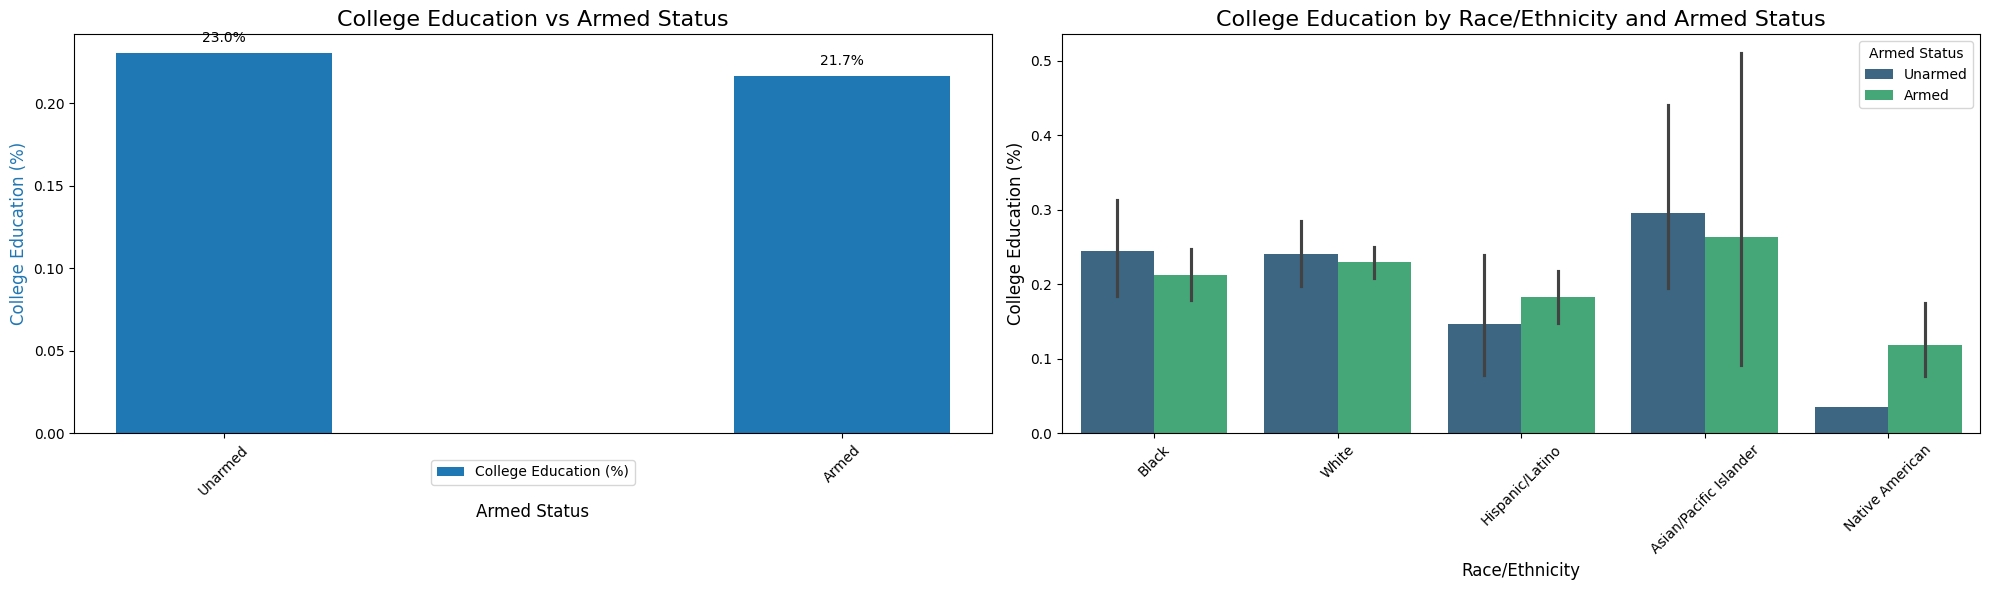

In [32]:

# Define the necessary variables
college_education = df['college']
categories = ['Unarmed', 'Armed']
armed_status_perc = {
    'Unarmed': df[df['is_armed'] == 'Unarmed']['college'].mean(),
    'Armed': df[df['is_armed'] == 'Armed']['college'].mean()
}
colors = ['tab:red', 'tab:green']

# Create the plot with updated colors and labels for exact percentages
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Bar width
bar_width = 0.35

# X-axis positions
x = np.arange(len(categories))

# Plot college education percentages
edu_bars = ax1.bar(
    x,
    [armed_status_perc[category] for category in categories],
    bar_width,
    label='College Education (%)',
    color='tab:blue'
)

# Add labels to college education bars
for bar, value in zip(edu_bars, [armed_status_perc[category] for category in categories]):
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.005,
        f'{value:.1%}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Add labels, legend, and title
ax1.set_xlabel('Armed Status', fontsize=12)
ax1.set_ylabel('College Education (%)', fontsize=12, color='tab:blue')
ax1.set_title('College Education vs Armed Status', fontsize=16)

ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=45)

# Adjust the legend and position
ax1.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -0.05), fontsize=10)

# Plot the old graph with race involved
sns.barplot(data=df, x='raceethnicity', y='college', hue='armed_status', palette='viridis', ax=ax2)
ax2.set_title('College Education by Race/Ethnicity and Armed Status', fontsize=16)
ax2.set_xlabel('Race/Ethnicity', fontsize=12)
ax2.set_ylabel('College Education (%)', fontsize=12)
ax2.legend(title='Armed Status', loc='upper right', fontsize=10)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-33-f371e81e2a6e>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')


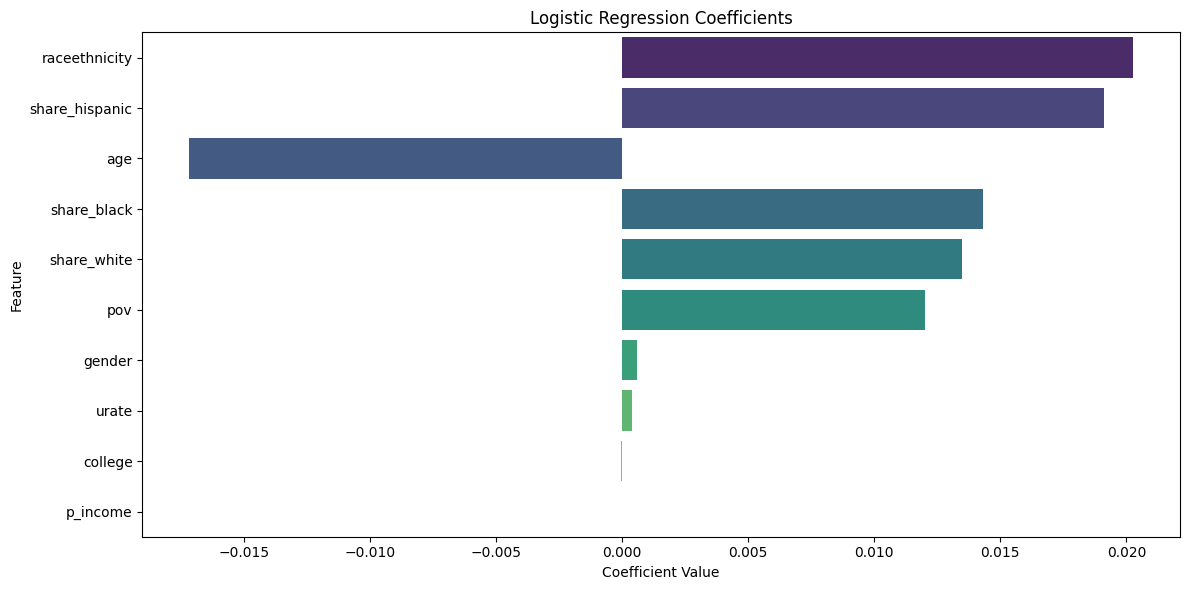

In [33]:
logreg = LogisticRegression()
logreg.fit(X, y)  # X and y are your features and target variable

# Get the coefficients and feature names
coefficients = logreg.coef_[0]  # Coefficients for the logistic regression model
feature_names = X.columns  # Feature names

# Create a DataFrame to hold feature names and coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort the coefficients by absolute value
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Plot the coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

<ipython-input-34-4601df8b0d2a>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df_svm, palette='plasma')


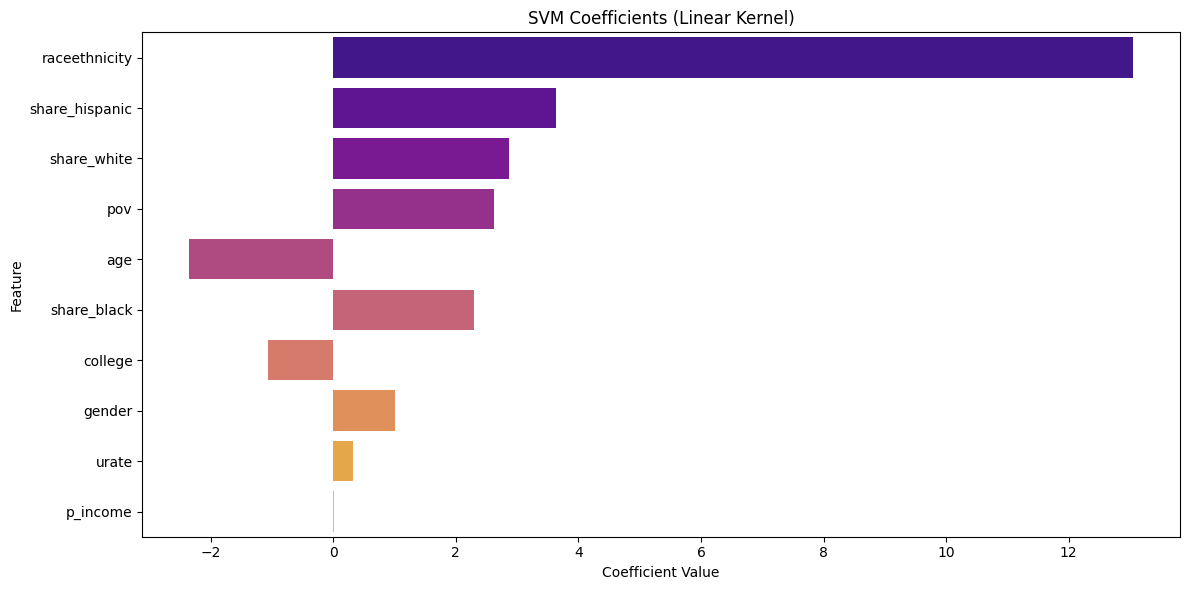

In [34]:
svm_model = SVC(kernel='linear')
svm_model.fit(X, y)

# Get the coefficients and feature names
svm_coefficients = svm_model.coef_[0]  # Coefficients of the linear SVM model
feature_names = X.columns  # Feature names

# Create a DataFrame to hold feature names and coefficients
coef_df_svm = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': svm_coefficients
})

# Sort the coefficients by absolute value
coef_df_svm = coef_df_svm.reindex(coef_df_svm['Coefficient'].abs().sort_values(ascending=False).index)

# Plot the coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df_svm, palette='plasma')
plt.title('SVM Coefficients (Linear Kernel)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()